In [1]:
using Pkg
Pkg.add("Interpolations")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed WeakRefStrings ─ v0.5.8
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [ea10d353] ↑ WeakRefStrings v0.5.7 ⇒ v0.5.8


In [2]:
using Interpolations

In [3]:
xs = range(0,π,length=5)
ys = sin.(xs)
;

In [4]:
itp0 = interpolate(ys, BSpline(Constant()));
sitp0 = scale(itp0, xs)

itp1 = interpolate(ys, BSpline(Linear()));
sitp1 = scale(itp1, xs)

itp2 = interpolate(ys, BSpline(Quadratic(Line(OnGrid()))));
sitp2 = scale(itp2, xs)

itp3 = interpolate(ys, BSpline(Cubic(Line(OnGrid()))));
sitp3 = scale(itp3, xs)
;

In [5]:
using PyPlot

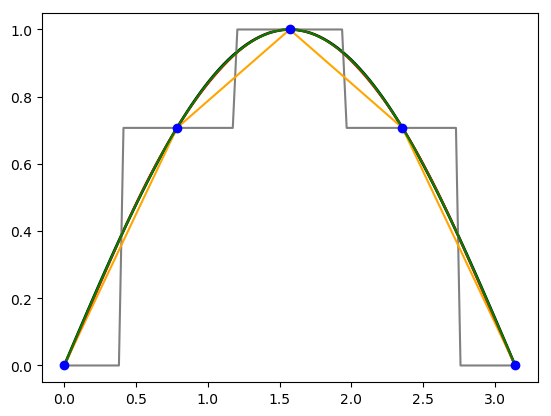

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc68dfd1358>

In [6]:
xinterp = range(0,pi,length=100)

plot( xinterp
    , sin.(xinterp)
    , color = "black"
    , linewidth = 2
    )

plot( xinterp
    , sitp0(xinterp)
    , color = "gray"
    )
plot( xinterp
    , sitp1(xinterp)
    , color = "orange"
    )
plot( xinterp
    , sitp2(xinterp)
    , color = "red"
    )
plot( xinterp
    , sitp3(xinterp)
    , color = "green"
    )
plot( xs
    , ys
    , linestyle = "None"
    , marker = "o"
    , color = "blue"
    )


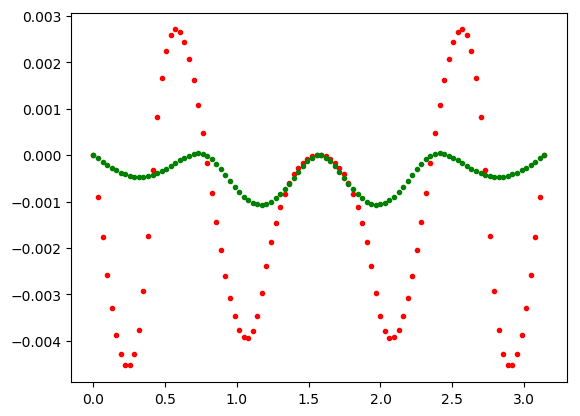

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc68de2fef0>

In [7]:
resid0 = sitp0(xinterp) - sin.(xinterp)
resid1 = sitp1(xinterp) - sin.(xinterp)
resid2 = sitp2(xinterp) - sin.(xinterp)
resid3 = sitp3(xinterp) - sin.(xinterp)

#plot( xinterp
#    , resid0
#    , color = "gray"
#    , linestyle = "none"
#    , marker = "."
#    )
#plot( xinterp
#    , resid1
#    , color = "orange"
#    , linestyle = "none"
#    , marker = "."
#    )
plot( xinterp
    , resid2
    , color = "red"
    , linestyle = "none"
    , marker = "."
    )
plot( xinterp
    , resid3
    , color = "green"
    , linestyle = "none"
    , marker = "."
    )

In [30]:
using StatsBase

In [119]:
function linear_sample( x1 :: Float64
                      , x2 :: Float64
                      , h1 :: Float64
                      , h2 :: Float64
                      )    :: Float64
    # if we imagine the area under a linear segment we can average the vertical positions
    # and multiply by the width
    xran = x2 - x1
    area = 0.5*(h1+h2)*xran
    # we can "normalize"
    y1 = h1/area
    y2 = h2/area
    
    m = (y2 - y1)/xran
    b  = y1 - m*x1
    b2 = y2 - m*x2
    @assert( isapprox(b,b2)
           , string( "Issue in linear sampling expected b=b2: instead (b,b2) = ("
                   , b
                   , ", "
                   , b2
                   , ")"
                   )
           )
    while true
        # using rejection sampling
        xsamp = xran*rand() + x1
        ysamp = rand()
        fxsamp = m*xsamp + b
        if ysamp <= fxsamp
            return xsamp
        end
    end
end

linear_sample (generic function with 2 methods)

In [133]:
x1,x2,y1,y2 = 2.0,5.0,0.3,0.4
area = 0.5*(y1+y2)*(x2-x1)
y1 /= area
y2 /= area
samps = [linear_sample(x1,x2,y1,y2) for i in 1:1000000]
;

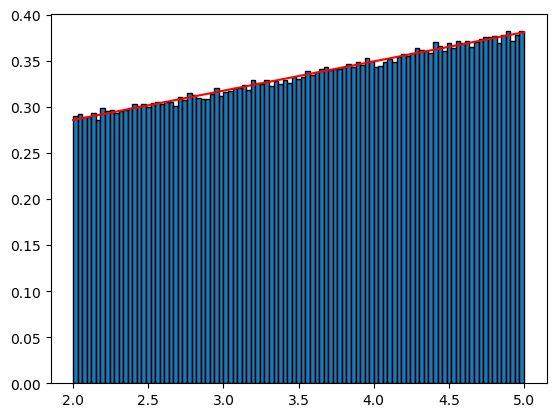

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc68c1a5b38>

In [134]:
edges = range(2,5,length=100)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)
h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
bar( h_edges
   , hist.weights
   , width = h_width
   , align = "edge"
   , edgecolor = "black"
   )
plot( [x1,x2]
    , [y1,y2]
    , color = "red"
    )

In [138]:
function sample_discrete( xs  :: AbstractVector
                        , pdf :: AbstractVector
                        , n   :: Int
                        ; res = 1000
                        )
    
    # interpolate the pdf with cubic spline with linear edges with knots on cell edges
    sitp = scale( interpolate( pdf
                             , BSpline( Cubic( Line( OnGrid()
                                                   )
                                             )
                                      )
                             )
                , xs
                )
    
    xfine = range(xs[1],xs[end],length=res)
    yfine = sitp(xfine)
    
    #-----------------------------------------------------------------------------------------------
    # from some of the tests the edges can be -1e-18
    ycheck1 = sum(yfine)
    # mask these values and set to zero
    mask = yfine .< 0
    yfine[mask] .= 0.0
    # make sure we didn't do anything unexpected
    ycheck2 = sum(yfine)
    @assert( isapprox(ycheck1,ycheck2)
           , "negative masking does not seem safe! Check the input pdf"
           )
    yfine ./= sum(yfine)
    #-----------------------------------------------------------------------------------------------
    
    # setup the weight vector
    pwgt = pweights(yfine)
    # sample the indices
    sinds = sample(1:res, pwgt, n) 
    
    # initialize the vector to hold the actual samples
    xsamp = Vector{Float64}(undef,n)
    
    for (i,ind) in enumerate(sinds)
        if ind == 1
            xsamp[i] = linear_sample( xfine[1]
                                    , xfine[2]
                                    , yfine[1]
                                    , yfine[2]
                                    )
        elseif ind == res
            xsamp[i] = linear_sample( xfine[res-1]
                                    , xfine[res]
                                    , yfine[res-1]
                                    , yfine[res]
                                    )
        else
            xsamp[i] = linear_sample( xfine[ind-1]
                                    , xfine[ind+1]
                                    , yfine[ind-1]
                                    , yfine[ind+1]
                                    )
        end
    end
            
    return xsamp
end

sample_discrete (generic function with 1 method)

In [144]:
#@show xs
#@show ys
ps = ys./sum(ys)
samps = sample_discrete(xs,ps,100000)
#@show samps
;

In [140]:
using StatsBase
import LinearAlgebra.normalize

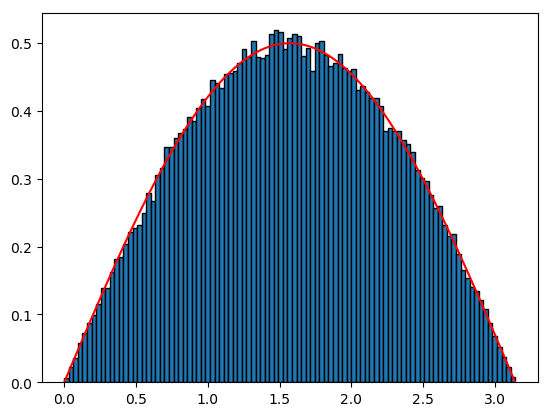

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc68b7a9550>

In [146]:
edges = range(0,π,length=100)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)

h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
bar( h_edges
   , hist.weights
   , width = h_width
   , align = "edge"
   , edgecolor = "black"
   )
x = range(0,π,length=100)
plot( x
    , sin.(x)./2
    , color = "red"
    )

In [16]:
using Interpolations
using LinearAlgebra
using PyPlot
using StatsBase

In [8]:
function rejection_sampling( xs :: AbstractVector
                           , ys :: AbstractVector
                           , n  :: Int
                           )
    
    # interpolate the pdf with cubic spline with linear edges with knots on cell edges
    sitp = scale( interpolate( ys
                             , BSpline( Cubic( Line( OnGrid()
                                                   )
                                             )
                                      )
                             )
                , xs
                )
    xran = xs[end] - xs[1]
    ymax = 1.1*maximum(ys)
    
    samp = Vector{Float64}(undef,n)
    i = 0
    while i < n
        xsamp = xran*rand() + xs[1]
        ysamp = ymax*rand()
        fxsamp = sitp(xsamp)
        if ysamp < fxsamp
            i+=1
            samp[i] = xsamp
        end
    end
    return samp
end

rejection_sampling (generic function with 1 method)

In [39]:
xs = range(0,π,length=5)
ys = sin.(xs)
;

In [36]:
xstep = x[2] - x[1]
area = sum(ys)*xstep
ps = ys./area
@show collect(xs)
@show ps
samps = rejection_sampling(xs,ps,1000000)
;

collect(xs) = [0.0, 0.785398, 1.5708, 2.35619, 3.14159]
ps = [0.0, 9.22985, 13.053, 9.22985, 1.59853e-15]


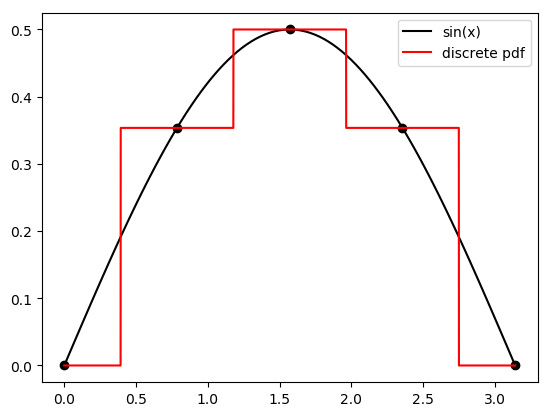

PyObject <matplotlib.legend.Legend object at 0x7fa34110ceb8>

In [75]:
edges = range(0,π,length=5)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)

h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
#bar( h_edges
#   , hist.weights
#   , width = h_width
#   , align = "edge"
#   , edgecolor = "black"
#   )
x = range(0,π,length=100)
plot( x
    , sin.(x)./2
    , color = "black"
    , label = "sin(x)"
    )
plot( xs
    , ys./2
    , linestyle = "None"
    , marker = "o"
    , color = "black"
    )

xinterp = range(0,π,length=10000)
itp0 = interpolate(ys, BSpline(Constant()))
sitp0 = scale(itp0, xs)
plot( xinterp
    , sitp0(xinterp)./2
    , color = "red"
    , label = "discrete pdf")

legend()

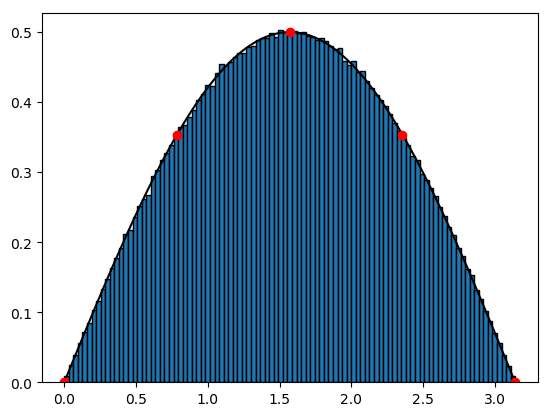

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa340e137f0>

In [77]:
edges = range(0,π,length=100)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)

h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
bar( h_edges
   , hist.weights
   , width = h_width
   , align = "edge"
   , edgecolor = "black"
   )
x = range(0,π,length=100)
plot( x
    , sin.(x)./2
    , color = "black"
    )

xinterp = range(0,π,length=10000)
itp0 = interpolate(ys, BSpline(Constant()))
sitp0 = scale(itp0, xs)
#plot( xinterp
#    , sitp0(xinterp)./2
#    , color = "red"
#    , linewidth = 2
#    )
plot( xs
    , ys./2
    , linestyle = "None"
    , marker = "o"
    , color = "red")


In [29]:
ps = ys./sum(ys)
@show collect(xs)
@show ps
samps = rejection_sampling(xs,ps,100)
;

collect(xs) = [0.0, 0.785398, 1.5708, 2.35619, 3.14159]
ps = [0.0, 0.292893, 0.414214, 0.292893, 5.07265e-17]


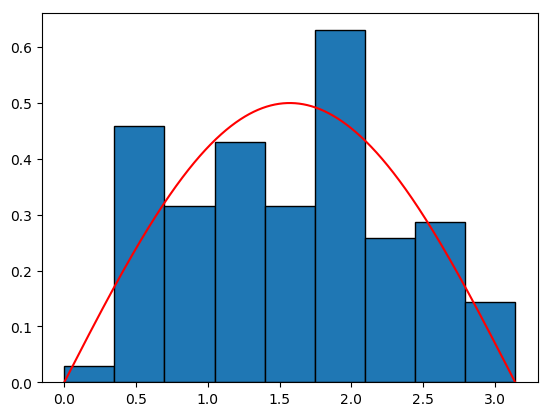

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa3425a9da0>

In [30]:
edges = range(0,π,length=10)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)

h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
bar( h_edges
   , hist.weights
   , width = h_width
   , align = "edge"
   , edgecolor = "black"
   )
x = range(0,π,length=10000)
plot( x
    , sin.(x)./2
    , color = "red"
    )

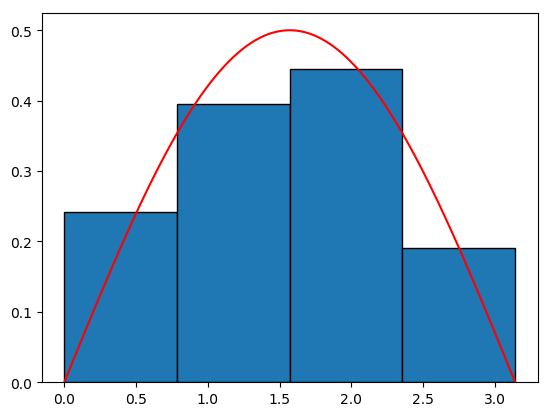

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa34246c2e8>

In [32]:
edges = range(0,π,length=5)
hist = normalize( fit(Histogram, samps, edges, closed=:left)
                , mode=:pdf)

h_edges = collect(hist.edges[1])
h_width = h_edges[2:end] .- h_edges[1:end-1]
pop!(h_edges)
bar( h_edges
   , hist.weights
   , width = h_width
   , align = "edge"
   , edgecolor = "black"
   )
x = range(0,π,length=100)
plot( x
    , sin.(x)./2
    , color = "red"
    )